In [2]:
import numpy as np
from scipy.optimize import minimize_scalar
import scipy

from evo.core import metrics

from evo.tools import log
log.configure_logging(verbose=True, debug=True, silent=False)

import pprint


from evo.tools import plot
import matplotlib.pyplot as plt
%matplotlib inline
%matplotlib notebook

import seaborn as sns

# temporarily override some package settings
from evo.tools.settings import SETTINGS
SETTINGS.plot_usetex = False


[DEBUG][2020-01-09 14:10:06,454][log.configure_logging():115]
System info:
Python 2.7.15+
Linux-4.15.0-72-generic-x86_64-with-Ubuntu-18.04-bionic
anne@ThinkPad-P50



Load two trajectory files in TUM format

In [79]:
from evo.tools import file_interface


ref_file = "room3_indexes/rgbd_dataset_freiburg3_long_office_household-groundtruth.txt"
est_file = "room3_indexes/KeyFrameTrajectory.txt"

traj_ref = file_interface.read_tum_trajectory_file(ref_file)
traj_est = file_interface.read_tum_trajectory_file(est_file)

[DEBUG][2020-01-09 17:40:01,617][file_interface.read_tum_trajectory_file():112]
Loaded 8710 stamps and poses from: room3_indexes/rgbd_dataset_freiburg3_long_office_household-groundtruth.txt
[DEBUG][2020-01-09 17:40:01,621][file_interface.read_tum_trajectory_file():112]
Loaded 183 stamps and poses from: room3_indexes/KeyFrameTrajectory.txt


In [80]:
from evo.core import sync
from evo.core import trajectory
max_diff = 0.01

traj_ref, traj_est = sync.associate_trajectories(traj_ref, traj_est, max_diff)
traj_est_aligned = trajectory.align_trajectory(traj_est, traj_ref, correct_scale=True, correct_only_scale=False)

[DEBUG][2020-01-09 17:40:03,019][sync.associate_trajectories():106]
Found 183 of max. 8710 possible matching timestamps between...
	first trajectory
and:	second trajectory
..with max. time diff.: 0.01 (s) and time offset: 0.0 (s).
[DEBUG][2020-01-09 17:40:03,022][trajectory.align_trajectory():394]
Aligning using Umeyama's method... (with scale correction)
[DEBUG][2020-01-09 17:40:03,030][trajectory.align_trajectory():404]
Rotation of alignment:
[[-9.95729737e-01 -6.18268187e-05 -9.23162381e-02]
 [ 8.05290716e-02  4.88358341e-01 -8.68919559e-01]
 [ 4.51371274e-02 -8.72643184e-01 -4.86267943e-01]]
Translation of alignment:
[-0.46976959  2.69930077  1.7533072 ]
[DEBUG][2020-01-09 17:40:03,033][trajectory.align_trajectory():405]
Scale correction: 2.40973404142


<IPython.core.display.Javascript object>


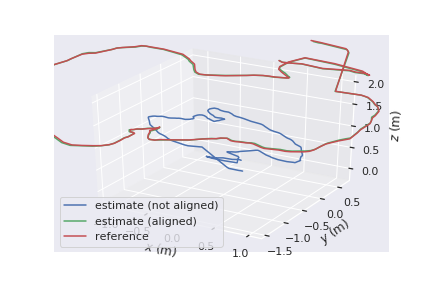

In [5]:
fig = plt.figure()
traj_by_label = {
    "estimate (not aligned)": traj_est,
    "estimate (aligned)": traj_est_aligned,
    "reference": traj_ref
}
plot.trajectories(fig, traj_by_label, plot.PlotMode.xyz)
plt.show()

In [6]:
pose_relation = metrics.PoseRelation.translation_part
use_aligned_trajectories = True

# use aligned trajectory
if use_aligned_trajectories:
    data = (traj_ref, traj_est_aligned) 
else:
    data = (traj_ref, traj_est)
    
ape_metric = metrics.APE(pose_relation)
ape_metric.process_data(data)

# get a single statistic
ape_stat = ape_metric.get_statistic(metrics.StatisticsType.rmse)
print(ape_stat)

ape_stats = ape_metric.get_all_statistics()
pprint.pprint(ape_stats)

[DEBUG][2020-01-09 14:10:30,920][metrics.process_data():374]
Compared 177 absolute pose pairs.
[DEBUG][2020-01-09 14:10:30,923][metrics.process_data():376]
Calculating APE for translation part pose relation...
0.021731727261
{'max': 0.05725084257309391,
 'mean': 0.01973234085531647,
 'median': 0.01878692060984594,
 'min': 0.0021525293211488725,
 'rmse': 0.021731727260979175,
 'sse': 0.08359143064496863,
 'std': 0.009105091658802446}


<IPython.core.display.Javascript object>


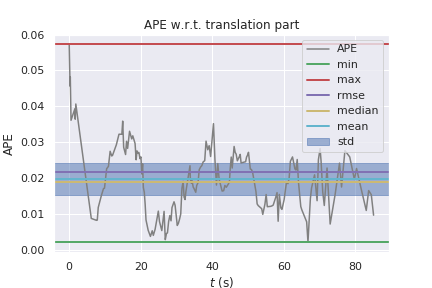

In [7]:
seconds_from_start = [t - traj_est.timestamps[0] for t in traj_est.timestamps]
fig = plt.figure()
plot.error_array(fig, ape_metric.error, x_array=seconds_from_start,
                 statistics={s:v for s,v in ape_stats.items() if s != "sse"},
                 name="APE", title="APE w.r.t. " + ape_metric.pose_relation.value, xlabel="$t$ (s)")
plt.show()

<IPython.core.display.Javascript object>


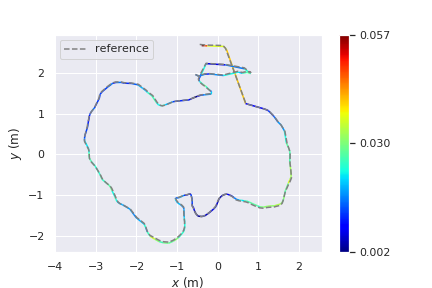

In [8]:
plot_mode = plot.PlotMode.xy
fig = plt.figure()
ax = plot.prepare_axis(fig, plot_mode)
plot.traj(ax, plot_mode, traj_ref, '--', "gray", "reference")
plot.traj_colormap(ax, traj_est_aligned if use_aligned_trajectories else traj_est, ape_metric.error, 
                   plot_mode, min_map=ape_stats["min"], max_map=ape_stats["max"])
ax.legend()
plt.show()

### Sparse scale estimation

In [46]:
room= "room3_indexes/"

sparse_points = np.load(room+'sparse_points.npy')
est_points = np.load(room+'est_points.npy')
targ_points = np.load(room+'targ_points.npy')
n_points = np.load(room+'n_depths.npy')
indexes = np.load(room+'indexes.npy')

indexes = indexes.reshape(len(indexes)/2,2)





In [107]:
from scipy import spatial

def cam_to_xyz(depths, indexes):
    # kinect params
    ratio = 0.475
    fx, fy = 525., 525.
    cx, cy = 319.5, 239.5
    
    fx *= ratio
    fy *= ratio
    cx *= ratio
    cy *= ratio
    
    u = indexes[:,1] # x is columns
    v = indexes[:,0] # y is rows
    
    x = (u - cx) * depths / fx
    y = (v - cy) * depths /fy 
    z = depths
    return zip(x.ravel(), y.ravel(), z.ravel())

def statistical_outlier_removal(data, k=20, std_mul=0.2):
    tree = spatial.cKDTree(data)
    distances, matches = tree.query(data, k)
    # remove self from matches
    distances = distances[:,1::]
    matches = matches[:,1::]

    _mean = np.mean(distances)
    _std = np.std(distances)

    mean_pp = np.mean(distances, axis=1)
    threshold = _mean + std_mul * _std
    rem_mask = mean_pp>threshold
    return rem_mask



In [108]:
%%time
data = cam_to_xyz(est_points, indexes)
rem_mask = statistical_outlier_removal(data)



CPU times: user 109 ms, sys: 0 ns, total: 109 ms
Wall time: 112 ms


In [12]:

def filter_mask(data):
    std_mul = .2
    
    mean = np.mean(data)
    stddev = np.std(data)
    
    threshold_max = mean + std_mul*stddev
    threshold_min = mean - std_mul*stddev
    
    return np.bitwise_or(data >= threshold_max, data <= threshold_min)
    
    

<IPython.core.display.Javascript object>


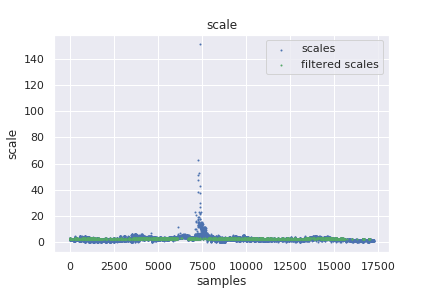

<IPython.core.display.Javascript object>


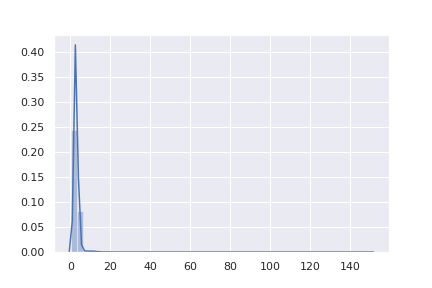

In [14]:
from scipy.ndimage import gaussian_filter1d

n_total = np.sum(n_points)

est_errors = est_points - sparse_points
est_scales = est_points/sparse_points

targ_scales = targ_points/sparse_points

# fiter errors
error_gaus = gaussian_filter1d(est_errors,100)
scale_gaus = gaussian_filter1d(est_scales,100)

# filter the scales
scale_mask = filter_mask(est_scales)
f_est_scales = np.copy(est_scales)
f_est_scales[scale_mask] = np.nan

scale_mask = filter_mask(targ_scales)
f_targ_scales = np.copy(targ_scales)
f_targ_scales[scale_mask] = np.nan


# plot

fig = plt.figure()
# plt.subplot(121)
plt.title("scale")
plt.xlabel("samples")
plt.ylabel("scale")
plt.scatter(np.arange(len(est_scales)), est_scales, s=1, label="scales")
plt.scatter(np.arange(len(f_est_scales)), f_est_scales, s=1, label="filtered scales")
# plt.scatter(np.arange(len(scale_gaus)), scale_gaus, s=1)
plt.legend()
plt.show()

# plt.subplot(122)
# plt.title("scale")
# plt.xlabel("samples")
# plt.ylabel("scale")
# plt.scatter(np.arange(len(targ_scales)), targ_scales, s=1, label="scales")
# plt.scatter(np.arange(len(f_targ_scales)), f_targ_scales, s=1, label="filtered scales")
# # plt.scatter(np.arange(len(scale_gaus)), scale_gaus, s=1)
# plt.legend()
# plt.show()

# fig = plt.figure()
# # plt.scatter(np.arange(len(error)), error, s=1)
# # plt.scatter(np.arange(len(_abs_error)), _abs_error, s=1)
# plt.scatter(np.arange(len(error_gaus)), error_gaus, s=1)
# plt.show()

fig = plt.figure()
sns.distplot(est_scales)
plt.show()

In [103]:
scipy.stats.describe(est_scales)
# scipy.stats.mode(scales)
# scipy.stats.tmean(scales, (1,4))
np.mean(error_gaus)
i = np.argmax(est_scales)

print(est_points[i])
print(sparse_points[i])
print(est_points[i])
scipy.stats.describe(est_scales)
print(np.nanmean(f_est_scales))

1.3801231384277344
0.00914779119193554
1.3801231384277344
2.7684842881277825


In [99]:
def _scale_error(scale, sparse, test):
    max_dist = 2.0

    scales = test/sparse
    rem_mask = filter_mask(scales)
    rem_mask = np.bitwise_and(rem_mask, test>max_dist)
    
    se = np.abs(scale*sparse[~rem_mask] - test[~rem_mask])**2
#     se = np.abs(scale*sparse - test)**2
    return se.sum()



min_scale = minimize_scalar(_scale_error, args=(sparse_points, est_points))
min_targ_scale = minimize_scalar(_scale_error, args=(sparse_points, targ_points))


print("est scale: %.3f" % min_scale.x)
print("targ scale: %.3f" % min_targ_scale.x)


n_prev = 0
frame_scales = []
old_frame_scales = []
frame_means = []
for n in n_points:
    if n == 0:
        continue
    
    i = np.arange(n_prev, n_prev+n)
    spar = sparse_points[i]
    est = est_points[i]
    targ = targ_points[i]
    
#     scales = est/spar
#     mask = filter_mask(scales)
    
    data = cam_to_xyz(sparse_points[i], indexes[i,:])
    mask = statistical_outlier_removal(data, k=40, std_mul=0.1)
   
    scales = scales[~np.isnan(scales)]
    old_frame_scales.append(np.mean(scales))

    frame_scale = minimize_scalar(_scale_error, args=(spar[~mask], est[~mask]))
    
    frame_scales.append(frame_scale.x)
    
    frame_means.append(np.mean(frame_scales))
    
    n_prev += n
print("frame by frame optimize: %.3f" % np.mean(frame_scales))
print("old frame by frame: %.3f" % np.mean(old_frame_scales))
    

est scale: 1.881
targ scale: 2.141
frame by frame optimize: 2.816
old frame by frame: 1.772


<IPython.core.display.Javascript object>


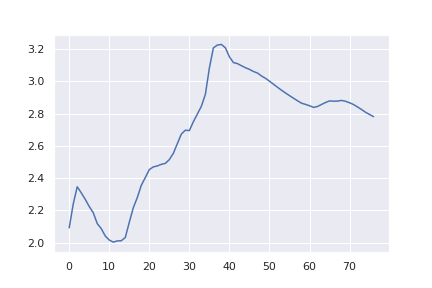

In [90]:
fig = plt.figure()
plt.plot(np.arange(len(frame_means)), frame_means)
plt.show()


## Filtering ORB points

mean error: 0.107
filtered mean error: 0.083


<IPython.core.display.Javascript object>


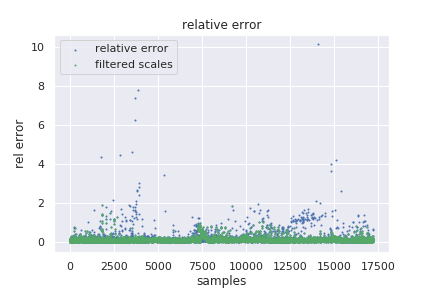

In [110]:
room_scale = 2.4

n_prev = 0
sparse_filter = np.array([])
for n in n_points:
    i = np.arange(n_prev, n_prev+n)
    
    data = cam_to_xyz(sparse_points[i], indexes[i,:])
    rem_mask = statistical_outlier_removal(data, k=20, std_mul=0.2)
    
    p = np.copy(sparse_points[i])
#     rem_mask = filter_mask(p)
    
    p[rem_mask]=np.nan
    sparse_filter = np.append(sparse_filter, p)
    
    n_prev += n
    
rel_error = np.abs((targ_points-room_scale*sparse_points)/targ_points)
rel_error_filter = np.abs((targ_points-room_scale*sparse_filter)/targ_points)


print("mean error: %.3f" % np.mean(rel_error))
print("filtered mean error: %.3f" % np.nanmean(rel_error_filter))
mask = np.isnan(sparse_filter)

fig = plt.figure()
plt.title("relative error")
plt.xlabel("samples")
plt.ylabel("rel error")
plt.scatter(np.arange(len(rel_error)), rel_error, s=1, label="relative error")
plt.scatter(np.arange(len(rel_error_filter)), rel_error_filter, s=1, label="filtered scales")
plt.legend()
plt.show()

In [95]:
print(mask.sum())
print(n_points.sum())

4148
17230


In [26]:
from scipy import spatial
x, y, z = np.mgrid[0:5, 2:8, 2:3]
data = zip(x.ravel(), y.ravel(), z.ravel())
tree = spatial.KDTree(data)
print 'ball', [data[i] for i in tree.query_ball_point(np.array([1,2,2]), 1)]
distance, index = tree.query(np.array([[2, 2, 2.2]]))
print 'query', distance, index, data[index[0]]
pts = np.array([[2, 2, 2.2]])

tree.query(pts)

import heapq
def euclideanDistance(x,y):
    return np.sqrt(sum([(a-b)**2 for (a,b) in zip(x,y)]))
closestPoints = heapq.nsmallest(1, enumerate(pts), key=lambda y: euclideanDistance(x, y[1]))

print closestPoints

ball [(0, 2, 2), (1, 2, 2), (1, 3, 2), (2, 2, 2)]
query [0.2] [12] (2, 2, 2)
[(0, array([2. , 2. , 2.2]))]
